In [1]:
import os
import numpy as np
%matplotlib inline

import metrics
import util

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 2672.46] [loc=0.993 scale=0.005]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 2672.46] [loc=0.993 scale=0.005]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.993004, scale:0.004799)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 131513] [loc=0.161 scale=0.366]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 131513] [loc=0.161 scale=0.366]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.161263, scale:0.366060)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 415.517] [loc=0.6

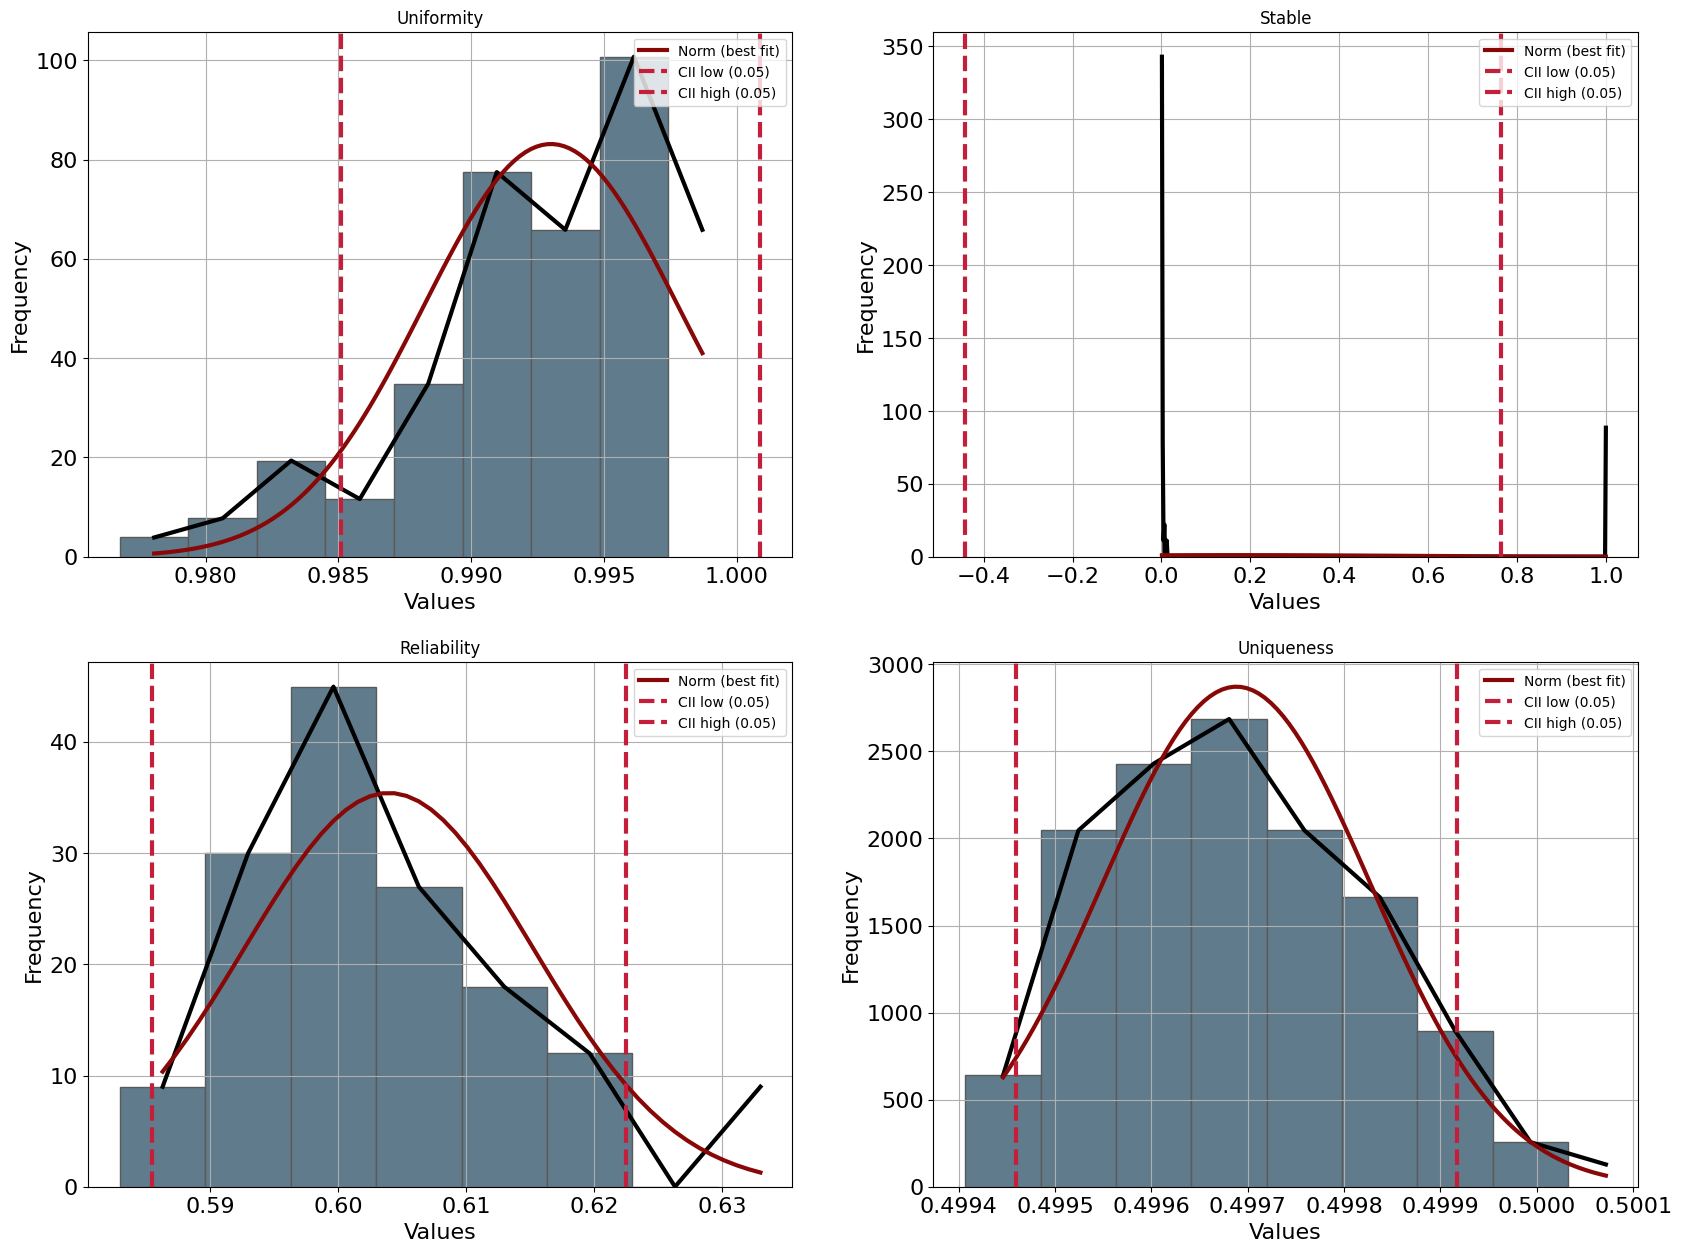

In [2]:
PD_COUNT = 100
PD_CENTER = 750
PD_SIGMA = 150
PD_DEVIATION_SIGMA = 0.30

NUMBER_OF_RESPONSES=100


pds = []
for i in range(50):
    pds.append(np.random.normal(PD_CENTER, PD_SIGMA, PD_COUNT))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES, PD_DEVIATION_SIGMA)
metrics.plot_metrics(res)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 8361.42] [loc=0.996 scale=0.003]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 8361.42] [loc=0.996 scale=0.003]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.995846, scale:0.003197)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 28.3468] [loc=0.536 scale=0.030]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 28.3468] [loc=0.536 scale=0.030]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.536180, scale:0.030098)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 1150.21] [loc=0

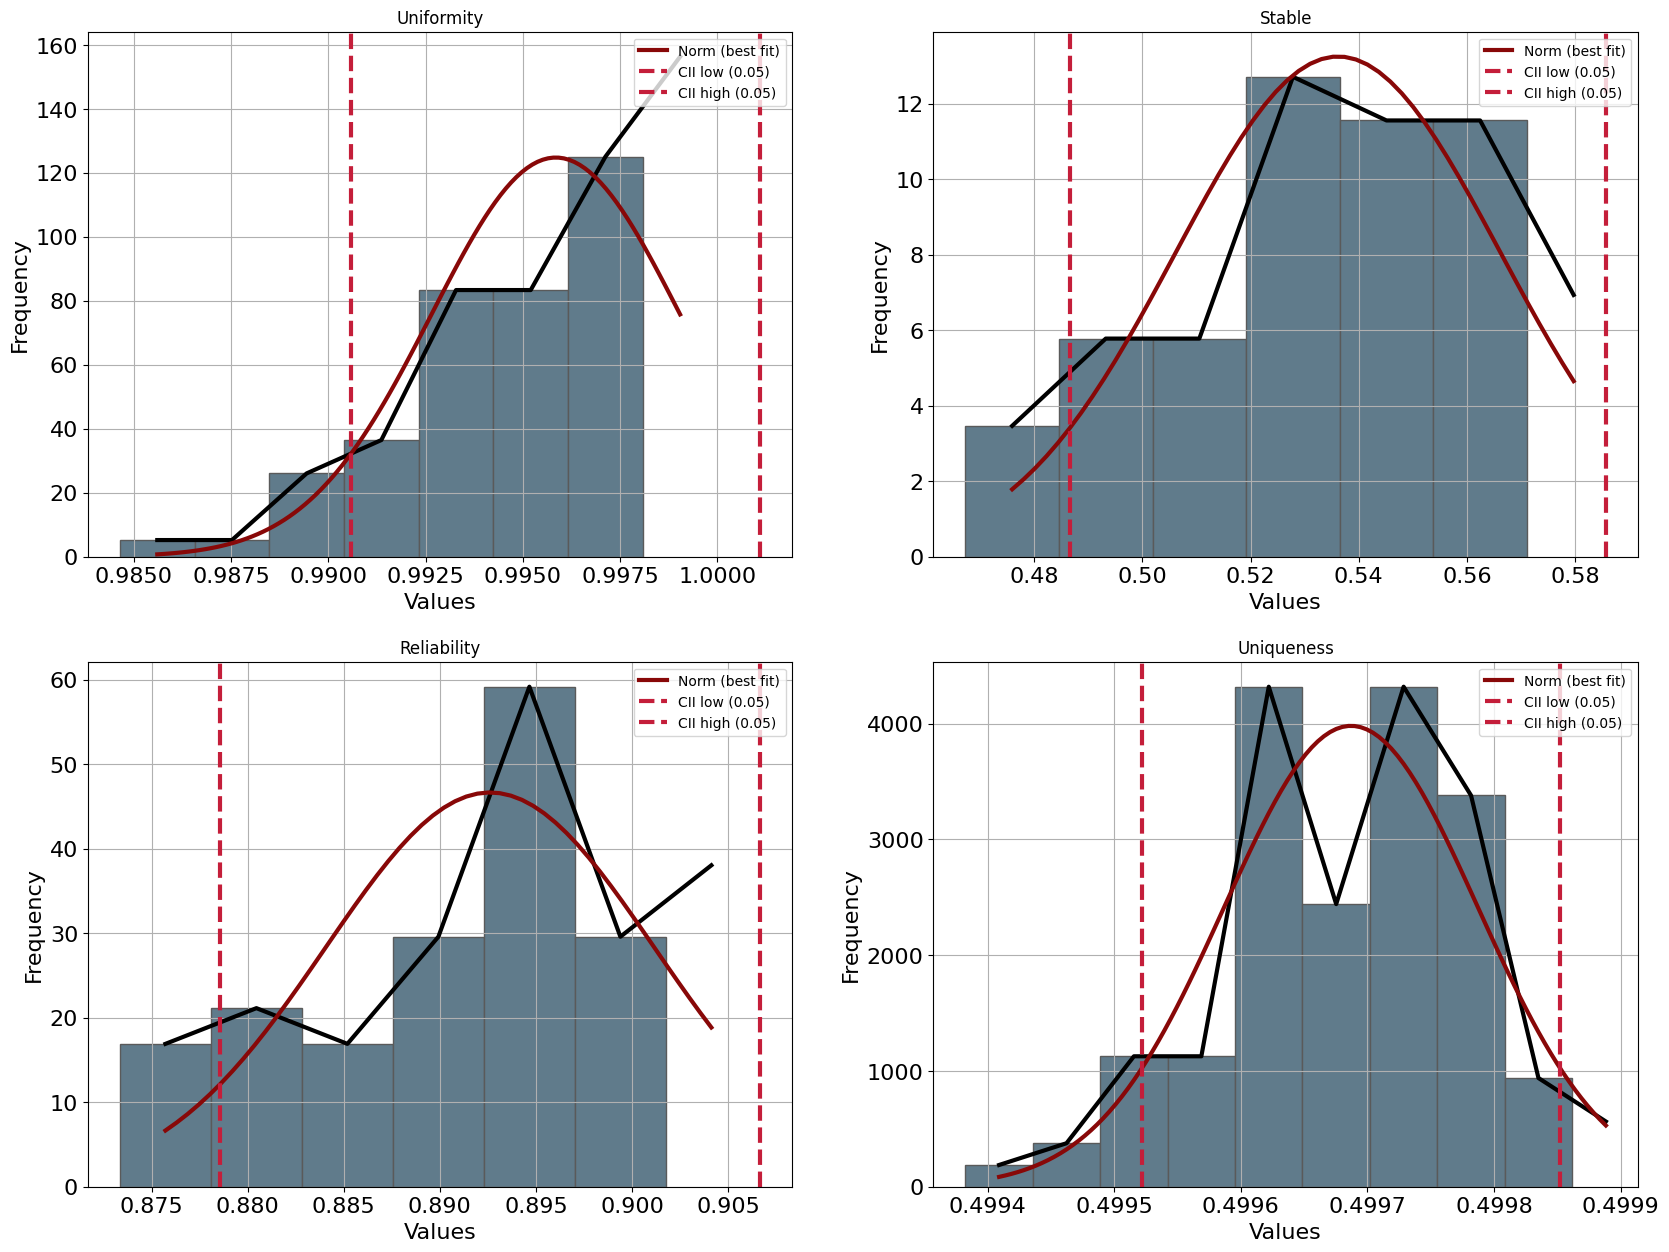

In [3]:
PD_COUNT = 100
PD_CENTER = 750
PD_SIGMA = 150
PD_DEVIATION_SIGMA = 0.05

NUMBER_OF_RESPONSES=100


pds = []
for i in range(50):
    pds.append(np.random.normal(PD_CENTER, PD_SIGMA, PD_COUNT))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES, PD_DEVIATION_SIGMA)
metrics.plot_metrics(res)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 7086.78] [loc=0.993 scale=0.006]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 7086.78] [loc=0.993 scale=0.006]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.992721, scale:0.006068)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:1.000000, scale:0.000000)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 81275.1] [loc=0.505 sca

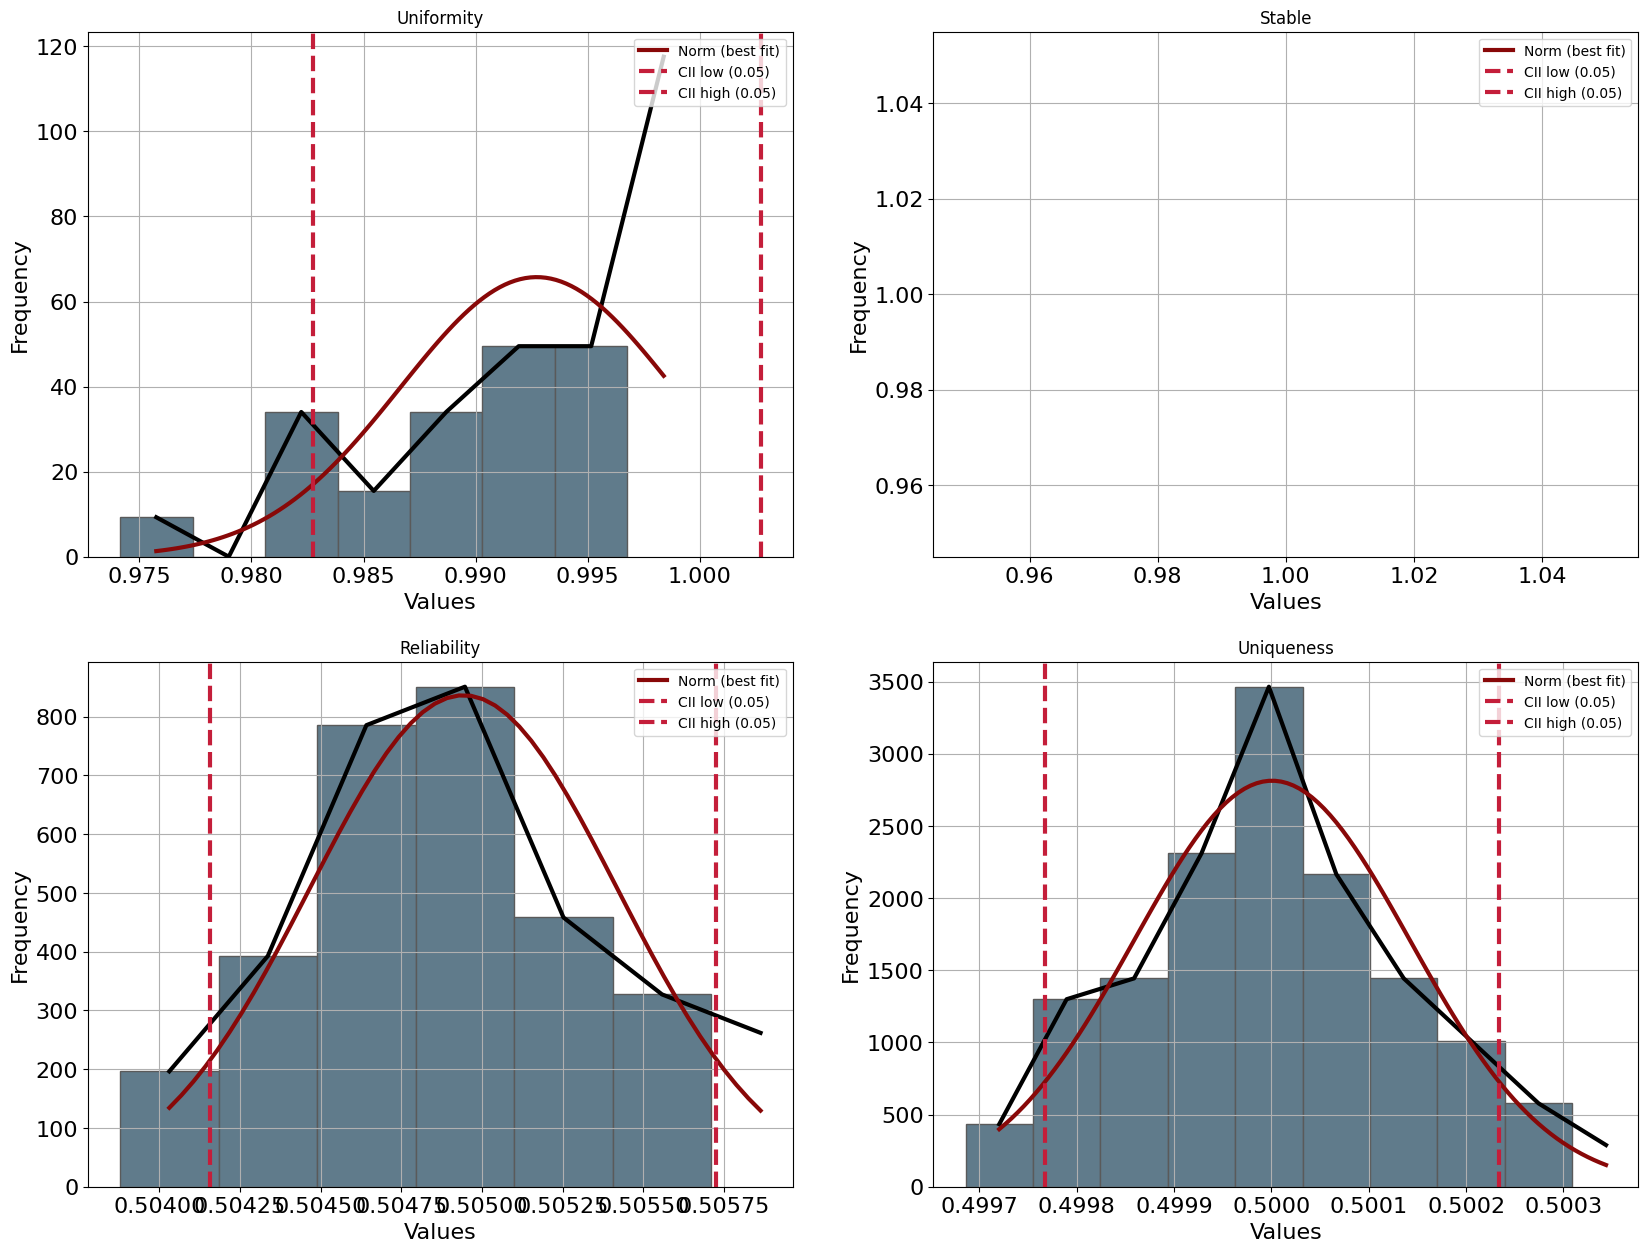

In [4]:
PD_COUNT = 100
PD_CENTER = 750
PD_SIGMA = 0
PD_DEVIATION_SIGMA = 0.05

NUMBER_OF_RESPONSES=100


pds = []
for i in range(50):
    pds.append(np.random.normal(PD_CENTER, PD_SIGMA, PD_COUNT))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES, PD_DEVIATION_SIGMA)
metrics.plot_metrics(res)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 2077.02] [loc=0.992 scale=0.006]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 2077.02] [loc=0.992 scale=0.006]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.991592, scale:0.006251)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:1.000000, scale:0.000000)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 217992] [loc=0.505 scal

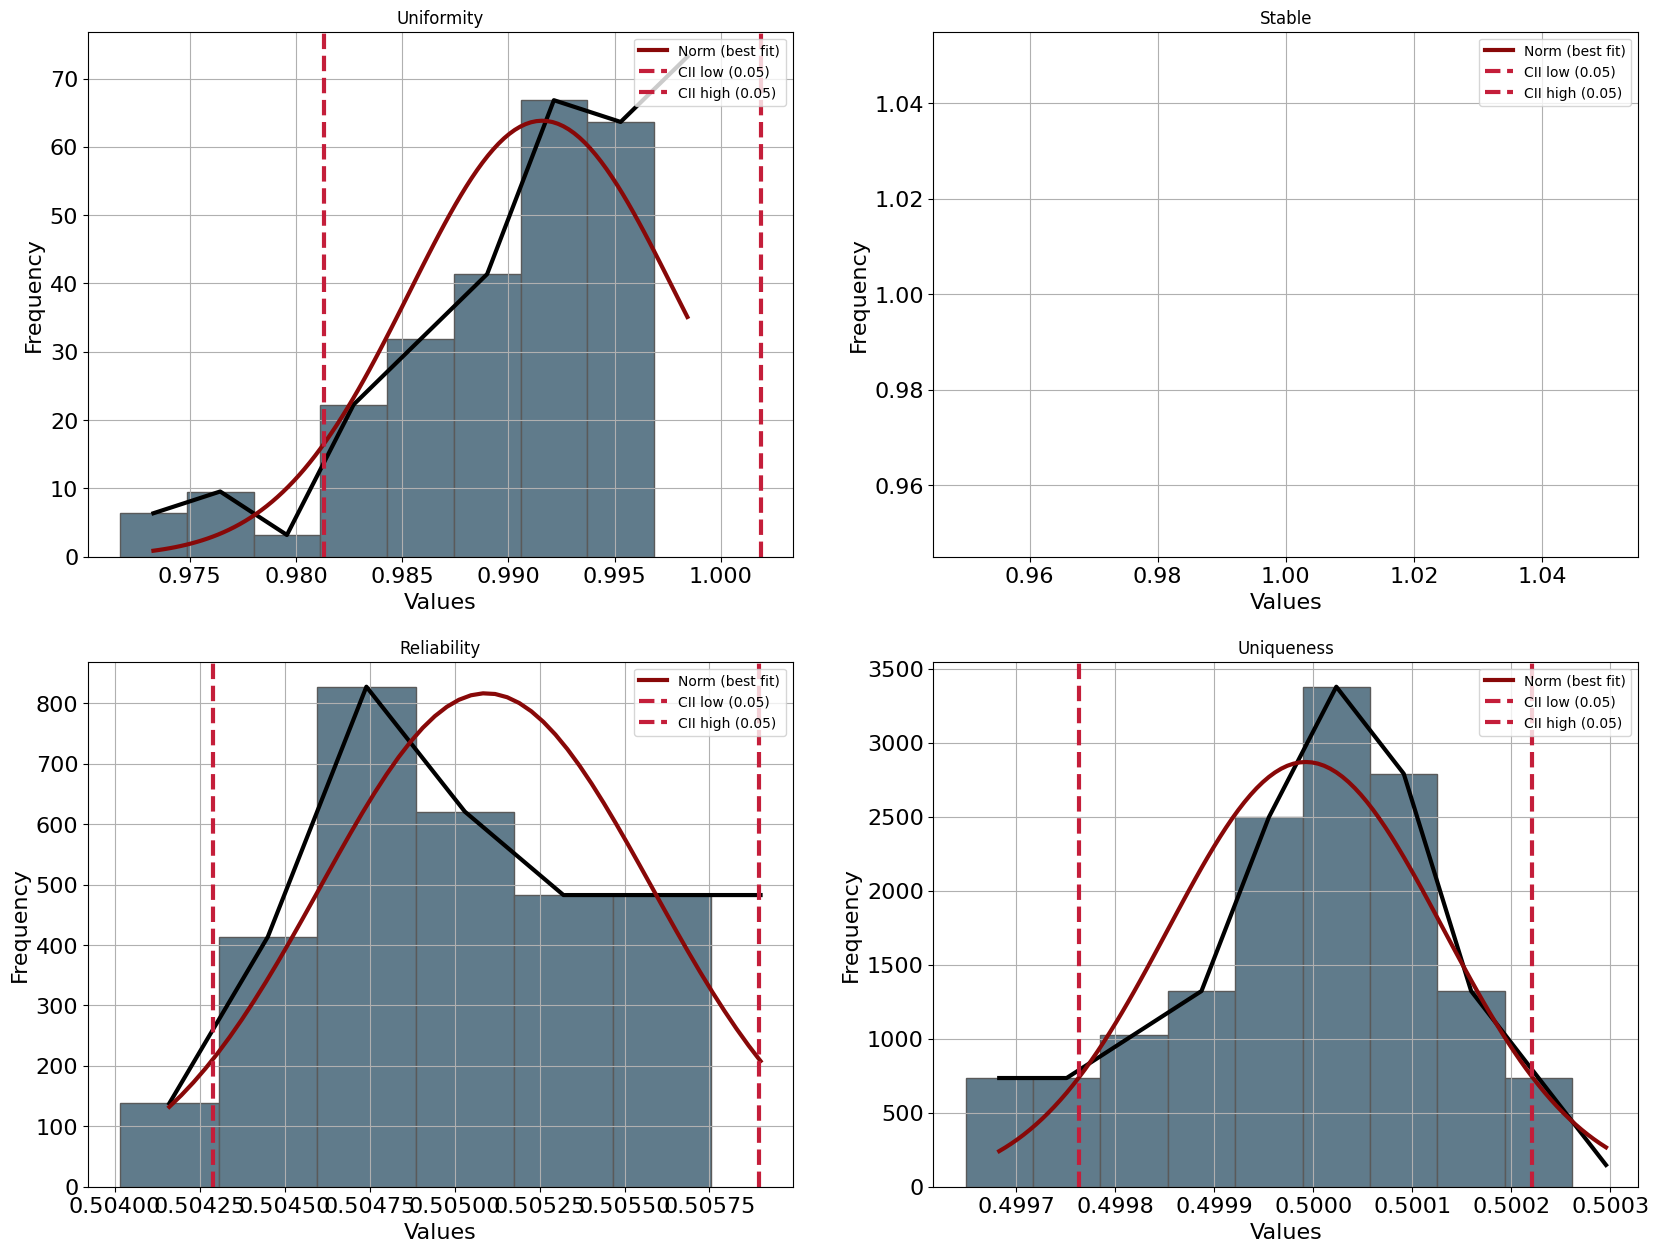

In [5]:
PD_COUNT = 100
PD_CENTER = 750
PD_SIGMA = 0
PD_DEVIATION_SIGMA = 0.3

NUMBER_OF_RESPONSES=100


pds = []
for i in range(50):
    pds.append(np.random.normal(PD_CENTER, PD_SIGMA, PD_COUNT))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES, PD_DEVIATION_SIGMA)
metrics.plot_metrics(res)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 3771.2] [loc=0.993 scale=0.005]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 3771.2] [loc=0.993 scale=0.005]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.992929, scale:0.004560)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:1.000000, scale:0.000000)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 83865.1] [loc=0.512 scale

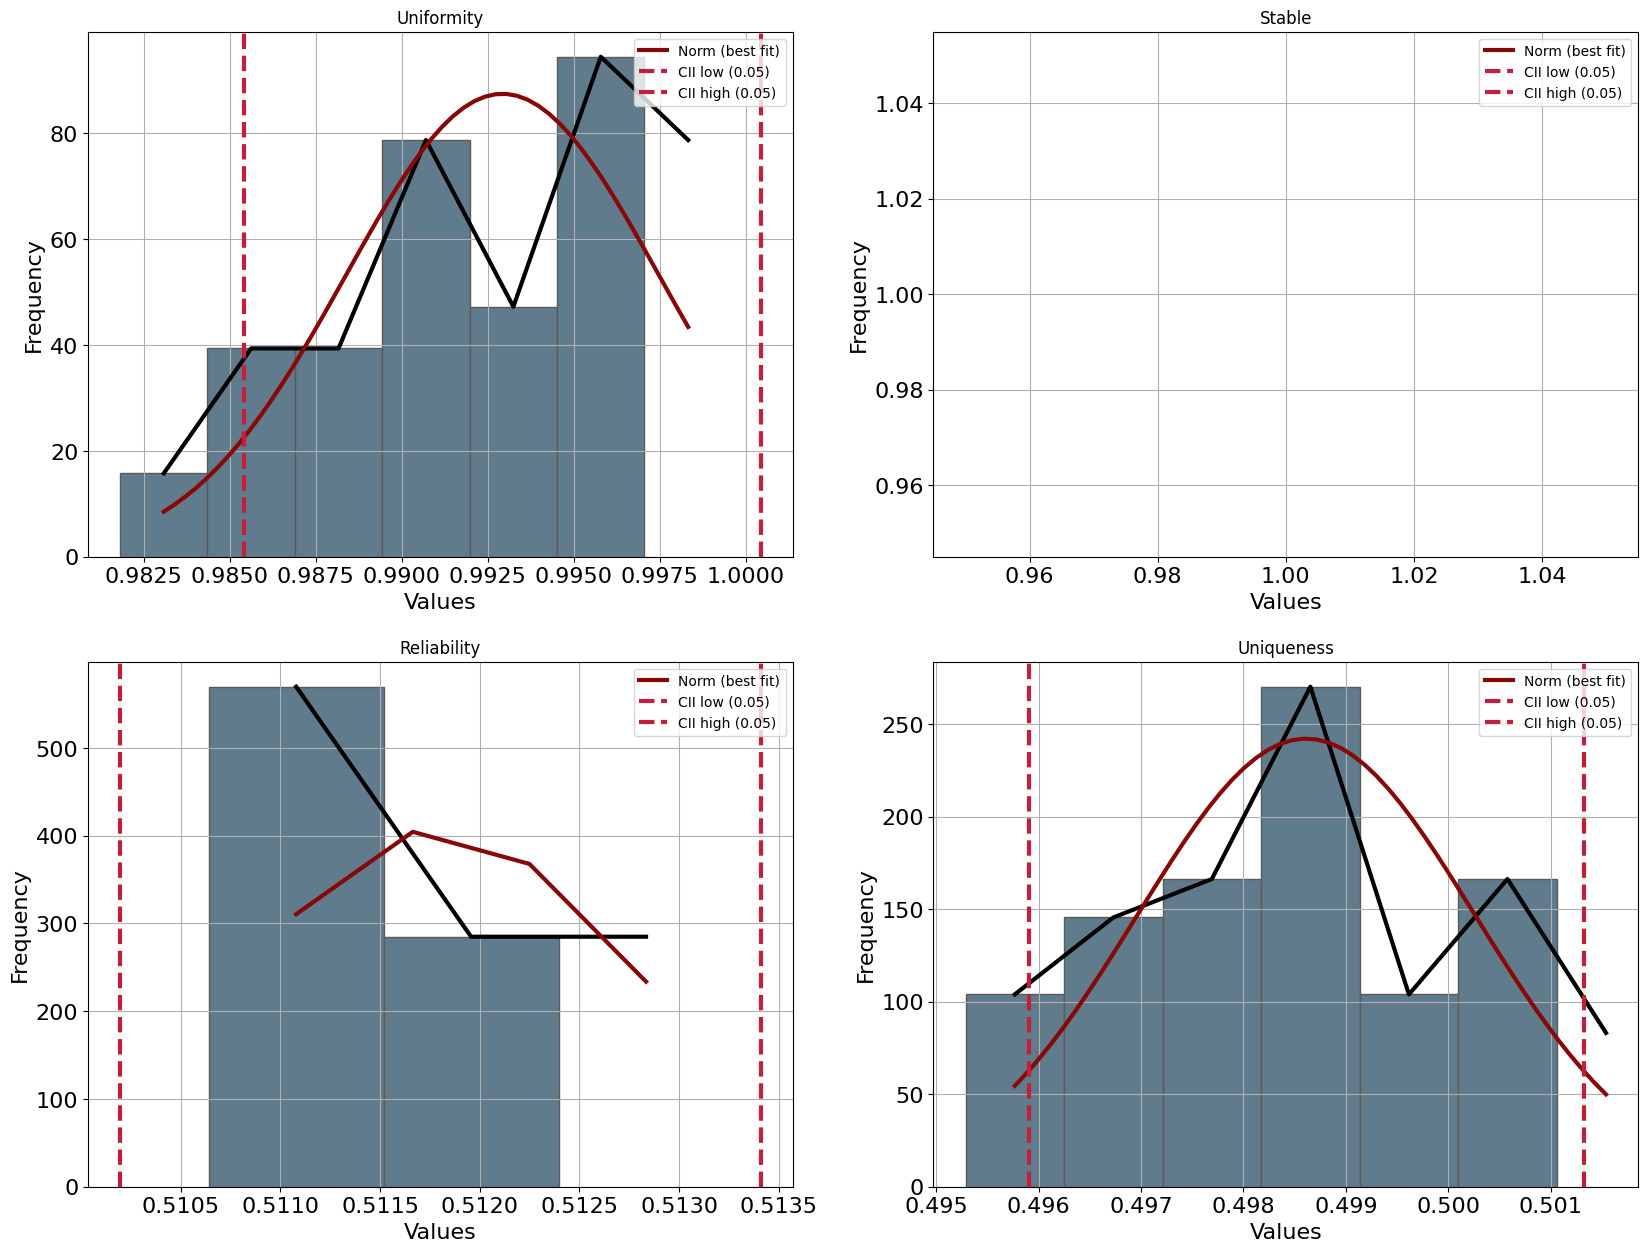

In [6]:
PD_DEVIATION_SIGMA = 0.05
NUMBER_OF_RESPONSES=50

pds = []

path = 'DataSet_01/F0/' 
for file in os.listdir(path): 
    file_path = f"{path}/{file}"
    with open(file_path, 'r') as f: 
        pds.append(util.read_pd_from_file(file_path))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES, PD_DEVIATION_SIGMA)
metrics.plot_metrics(res)


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 2611.96] [loc=0.992 scale=0.006]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 2611.96] [loc=0.992 scale=0.006]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.991669, scale:0.006243)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=1.000 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:1.000000, scale:0.000000)
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 1.05156e+06] [loc=0.512

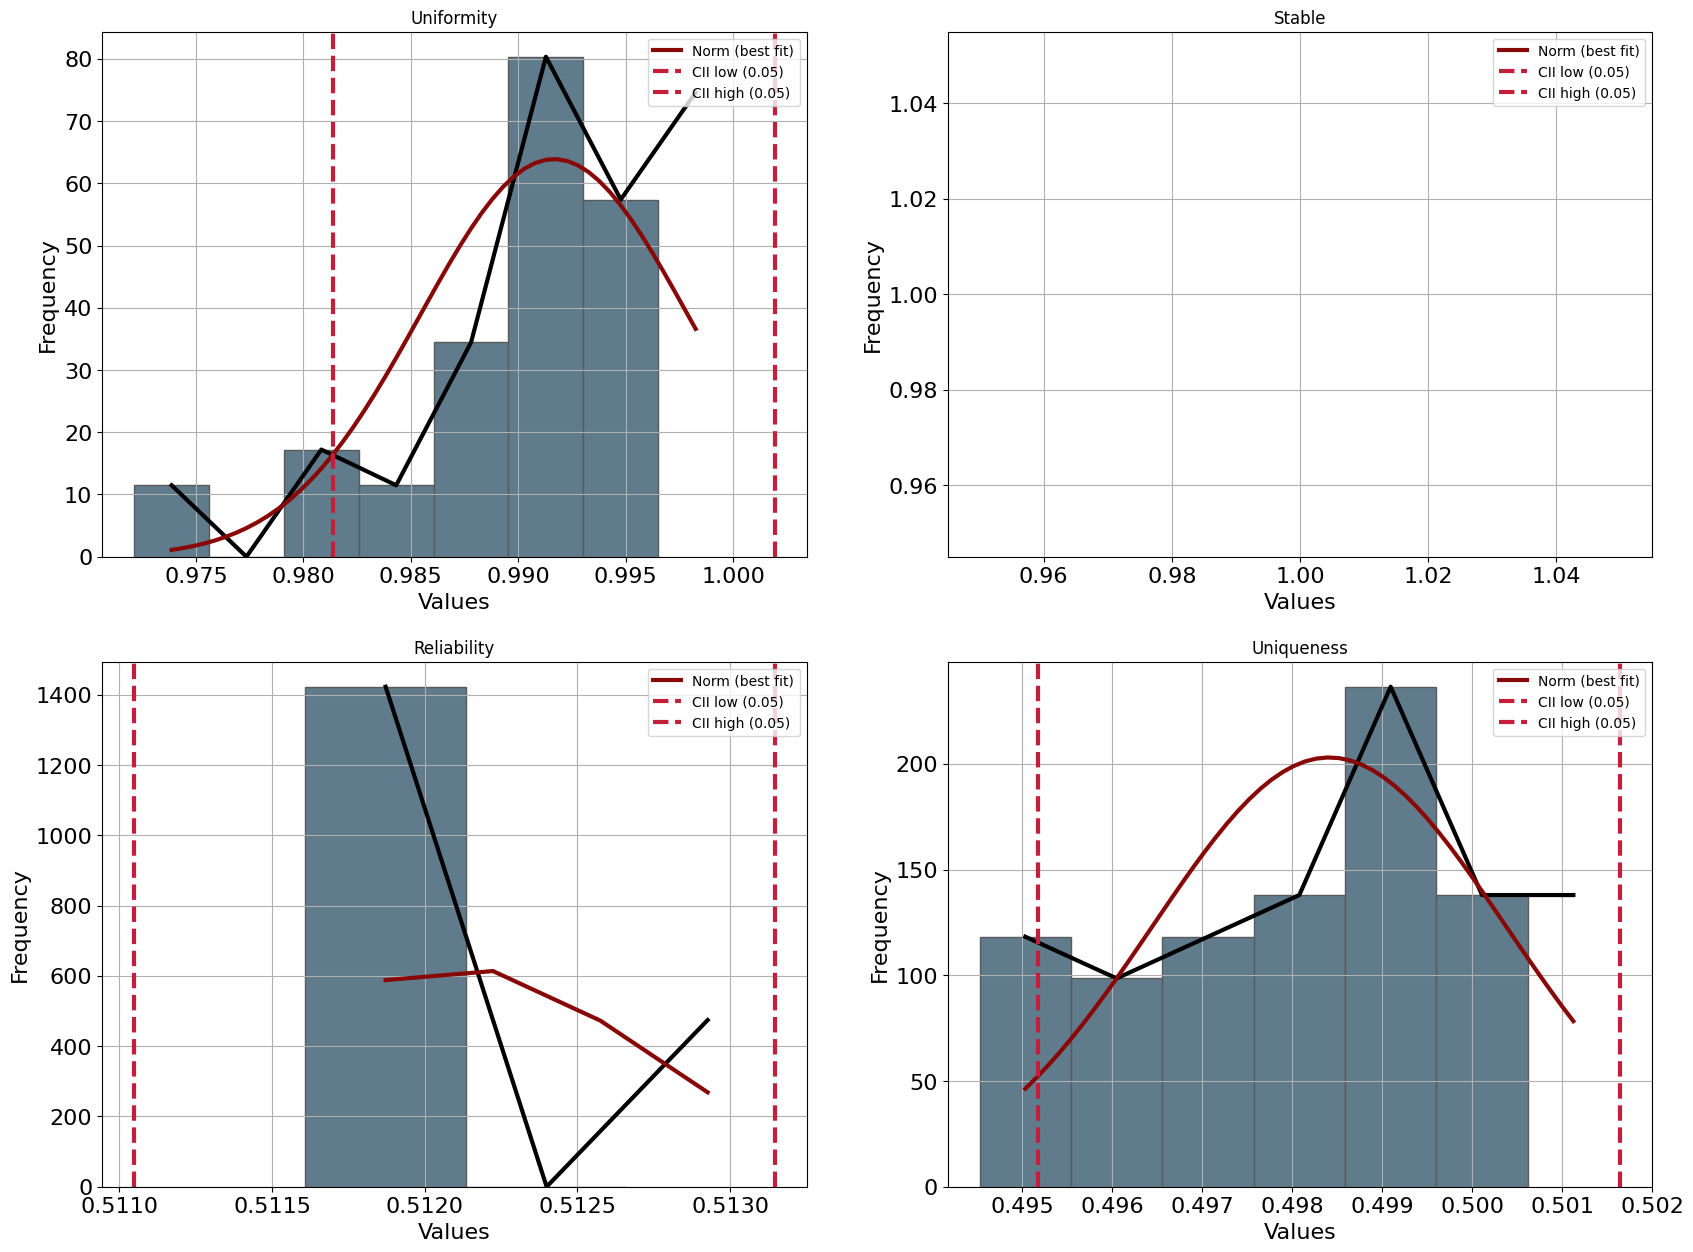

In [7]:
PD_DEVIATION_SIGMA = 0.05
NUMBER_OF_RESPONSES=50

pds = []

paths = ['DataSet_01/F0/CRO_REAL_FIXED_F0_C0.txt',
        'DataSet_01/F1/CRO_REAL_FIXED_F1_C0.txt',
        'DataSet_01/F2/CRO_REAL_FIXED_F2_C0.txt',
        'DataSet_01/F3/CRO_REAL_FIXED_F3_C0.txt']

for path in paths:
    pds.append(util.read_pd_from_file(file_path))

res = metrics.calc_metrics(pds, NUMBER_OF_RESPONSES, PD_DEVIATION_SIGMA)
metrics.plot_metrics(res)


In [8]:
def read_dataset_pairs_responses(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        pairs = dict()

        for l in lines:
            v = l.split(' ')
            pairs[(int(v[0]), int(v[1]))] = (int(v[2]), int(v[3]), int(v[4]), int(v[5]))

        return pairs

def read_pds(paths: list) -> list:
    for path in paths:
        pds.append(util.read_pd_from_file(path))

golden_val = read_dataset_pairs_responses('DataSet_02/F0/CRO_REAL_FIXED_F0_10k.txt')
paths = ['DataSet_01/F0/CRO_REAL_FIXED_F0_C0.txt',
        'DataSet_01/F0/CRO_REAL_FIXED_F0_C1.txt',
        'DataSet_01/F0/CRO_REAL_FIXED_F0_C2.txt',
        'DataSet_01/F0/CRO_REAL_FIXED_F0_C3.txt']
pds = read_pds(path)

calc = dict()
for pair in golden_val.keys:
    res = [0, 0, 0, 0]
    for i in range(100):
            
        t = [0, 0, 0, 0]
        


def cmp_pd(a, b) -> int:
    return (a > b).astype(int)



        

FileNotFoundError: [Errno 2] No such file or directory: 'D'